# Sistemas Inteligentes 2021/2022

## Mini-projeto 3: Aprendizagem Automática

## Relatório


## Grupo: 51

Número: 56926    Nome: Lucas Pinto   
Número: 56895    Nome: Matilde Silva    
Número: 56941    Nome: Bruno Gonzalez

In [1]:
# Helpers
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)


## 1. Processamento dos dados

- Usar o pandas para abrir o ficheiro "train.csv"
- Criação das tabelas e identificação das mesmas

#COPIADO DA PL -Guiao arvores
Como explicado anteriormente, os classificadores do scikit-learn, contudo, não podem usar dados categóricos na matriz de dados, pelo que estes terão que ser binarizados, ou seja cada valor possível de uma variável é transformado numa coluna que pode ter valores 1 ou 0, consoante esse valor ocorra ou não. A função get_dummies() do pandas permite efectuar essa transformação sem problemas dentro de um DataFrame.



In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df_cirrose_train = pd.read_csv("train.csv")

col_idxs = [x for x in range(1, 19)]
col_names = np.array(df_cirrose_train.columns)[col_idxs]

X = df_cirrose_train.values[:, col_idxs]
y = df_cirrose_train.values[:, 19]
y = y.astype('int')

dummy_col_names = ['Status', 'Drug', 'Sex',
                   'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

dummy_col_names = ['Status', 'Drug',  # 'Sex',
                   'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

df_cirrose_X = df_cirrose_train[col_names]
df_cirrose_X.drop('Sex', axis=1, inplace=True)


def replace_dummies(df):
    df['Status'].replace(['C', 'D', 'CL'],
                         [0, 1, 2], inplace=True)

    df['Drug'].replace(['Unknown', 'D-penicillamine', 'Placebo'],
                       [0, 1, 2], inplace=True)

    # df['Sex'].replace(['F', 'M'],
    #                   [0, 1], inplace=True)

    df['Ascites'].replace(['Unknown', 'N', 'Y'],
                          [0, 1, 2], inplace=True)

    df['Hepatomegaly'].replace(['Unknown', 'N', 'Y'],
                               [0, 1, 2], inplace=True)

    df['Spiders'].replace(['Unknown', 'N', 'Y'],
                          [0, 1, 2], inplace=True)

    df['Edema'].replace(['N', 'S', 'Y'],
                        [0, 1, 2], inplace=True)


df_cirrose_Xdum = df_cirrose_X.copy()
replace_dummies(df_cirrose_Xdum)
# df_cirrose_Xdum = pd.get_dummies(df_cirrose_X, columns=dummy_col_names)
col_names_dum = np.array(df_cirrose_Xdum.columns)

# df_cirrose_Xdum.drop('Sex', axis=1, inplace=True)
Xdum = df_cirrose_Xdum.values

X_train, X_test, y_train, y_test = train_test_split(
    Xdum, y, test_size=0.2, random_state=2)


/tmp/ipykernel_10273/514606582.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cirrose_X.drop('Sex', axis=1, inplace=True)


In [24]:
df_cirrose_Xdum

,N_Days,Status,Drug,Age,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,2644,0,1,20296,1,1,1,0,0.5,369.510563,3.85,63.000000,663.000000,79.050000,124.702128,311.0,9.7
1,3492,0,0,21915,0,0,0,0,0.6,369.510563,4.38,97.648387,1982.655769,122.556346,124.702128,269.0,10.6
2,1702,0,1,18806,1,1,1,0,1.1,414.000000,3.44,80.000000,1003.000000,99.000000,55.000000,271.0,9.6
3,3523,0,0,14610,0,0,0,0,0.6,369.510563,4.04,97.648387,1982.655769,122.556346,124.702128,130.0,11.2
4,3428,1,2,13727,1,2,2,2,3.3,299.000000,3.55,131.000000,1029.000000,119.350000,50.000000,199.0,11.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,2255,0,1,22642,1,1,1,0,0.6,213.000000,4.07,12.000000,5300.000000,57.350000,68.000000,240.0,11.0
325,1899,0,0,14975,0,0,0,0,1.7,369.510563,3.66,97.648387,1982.655769,122.556346,124.702128,92.0,11.0
326,1152,1,1,25546,1,2,1,0,2.3,586.000000,3.01,243.000000,2276.000000,114.700000,126.000000,339.0,10.9
327,71,1,1,18972,1,2,2,1,12.2,394.000000,3.08,111.000000,2132.000000,155.000000,243.000000,165.0,11.6


## 2. Ajustamento dos modelos


### 2.1. Teste de modelos e validação

(remover) Enunciar as várias abordagens testadas para
* Criar modelos
* Validar modelos
* Avaliar a qualidade dos modelos


#COPIADO   das aulas - guiao arvores
Existe naturalmente nesta biblioteca uma classe para ajustar um classificador usando Árvores de Decisão sendo altamente parametrizável, a classe DecisionTreeClassifier.
criterion = entropy - Critério utilizado para medir a qualidade da partição, proporcionada pelo atributo, o ganho de informação (entropy)
max_depth - por defeito é None, mas pode-se escolher um valor inteiro para este parâmetro. Este parâmetro define a profundidade máxima da árvore a gerar.

Vamos então criar uma árvore de decisão com o critério do ganho de informação e deixando os outros parâmetros inalterados. Primeiro é necessário criar o objeto da árvore de decisão, onde se definem os parâmetros necessários. Depois podem-se usar os seguintes métodos:
predict(X) - prevê o valor da classe para os dados X

Incializar o classificador, eventualmente definindo os parâmetros de ajustamento
Ajustar o classificador aos dados usando o método fit(X, y) que recebe uma matriz de dados (X), que deve ser um numpy.array, e um correspondente conjunto de saída etiquetado (y)
Fazer previsões para um conjunto novo de dados usando o método predict(X) em que o método recebe uma matriz de dados e retornará os valores previstos

#avaliar qualidade?
Depois de construido o modelo podemos usá-lo para prever novos exemplos. Neste caso vamos testar com os mesmos dados com que o treinamos e verificar se os resultados são coerentes.

#validar PL Avaliacao de modelos
Para validar o modelo fornecemos novos dados (que não foram vistos pelo modelo) para os quais temos classes. Isto normalmente é feito dividindo o conjunto de dados (neste caso os 150 exemplos do conjunto iris) em duas partes. Uma parte dos dados, designada de conjunto de treino, é usada para treinar o nosso modelo, enquanto os restantes exemplos, formam o conjunto de teste e serão usados para verificar o quão bem o modelo funciona.

O scikit-learn tem uma função train_test_split que mistura (shuffle) o conjunto de dados e divide-o em duas partes. Esta função, por defeito, extrai 75% das linhas do conjunto de dados para o conjunto de treino, com as classes correspondentes. Os restantes 25% dos dados com as respetivas classes constituem o conjunto de teste. Estas percentagens podem ser ajustadas consoante o conjunto de dados que se tem, mas dividir 75%-25% é um boa regra de bolso (rule of thumb).
os primeiros dois argumentos são sempre a matriz dos dados e o vector de classes
test_size - por defeito usa o complemento do train_size ou 0.25 se train_size não for definido, e corresponde à percentagem de pontos a considerar no conjunto de teste
train_size - por defeito usa o complemento do test_size, e corresponde à percentagem de pontos a considerar no conjunto de treino
random_state - controla a aleatoriedade na escolha de pontos, se fixarmos a um valor inteiro qualquer, é possível replicar a mesma divisão dos dados e replicar resultados
e devolve quatro outputs, o conjunto de treino (designemo-lo por X_train) e de teste (X_test) que são matrizes (numpy arrays) com os dados e as classes de treino (y_train) e teste (y_test) que serão vectores (numpy array).

In [25]:
# Árvore de Decisão
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


dt = DecisionTreeClassifier(max_depth=9, min_samples_split=12, min_samples_leaf=25, random_state=2)
dt.fit(X_train, y_train)

dt_preds = dt.predict(X_test)

scores = cross_val_score(dt,
                         X=X_train,
                         y=y_train,
                         cv=10
                        )
print('CV accuracy:', *scores, sep='\n\t')
print('Average CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))


CV accuracy:
	0.5185185185185185
	0.48148148148148145
	0.37037037037037035
	0.4230769230769231
	0.46153846153846156
	0.5384615384615384
	0.4230769230769231
	0.5
	0.4230769230769231
	0.5
Average CV accuracy: 0.464 +/- 0.050


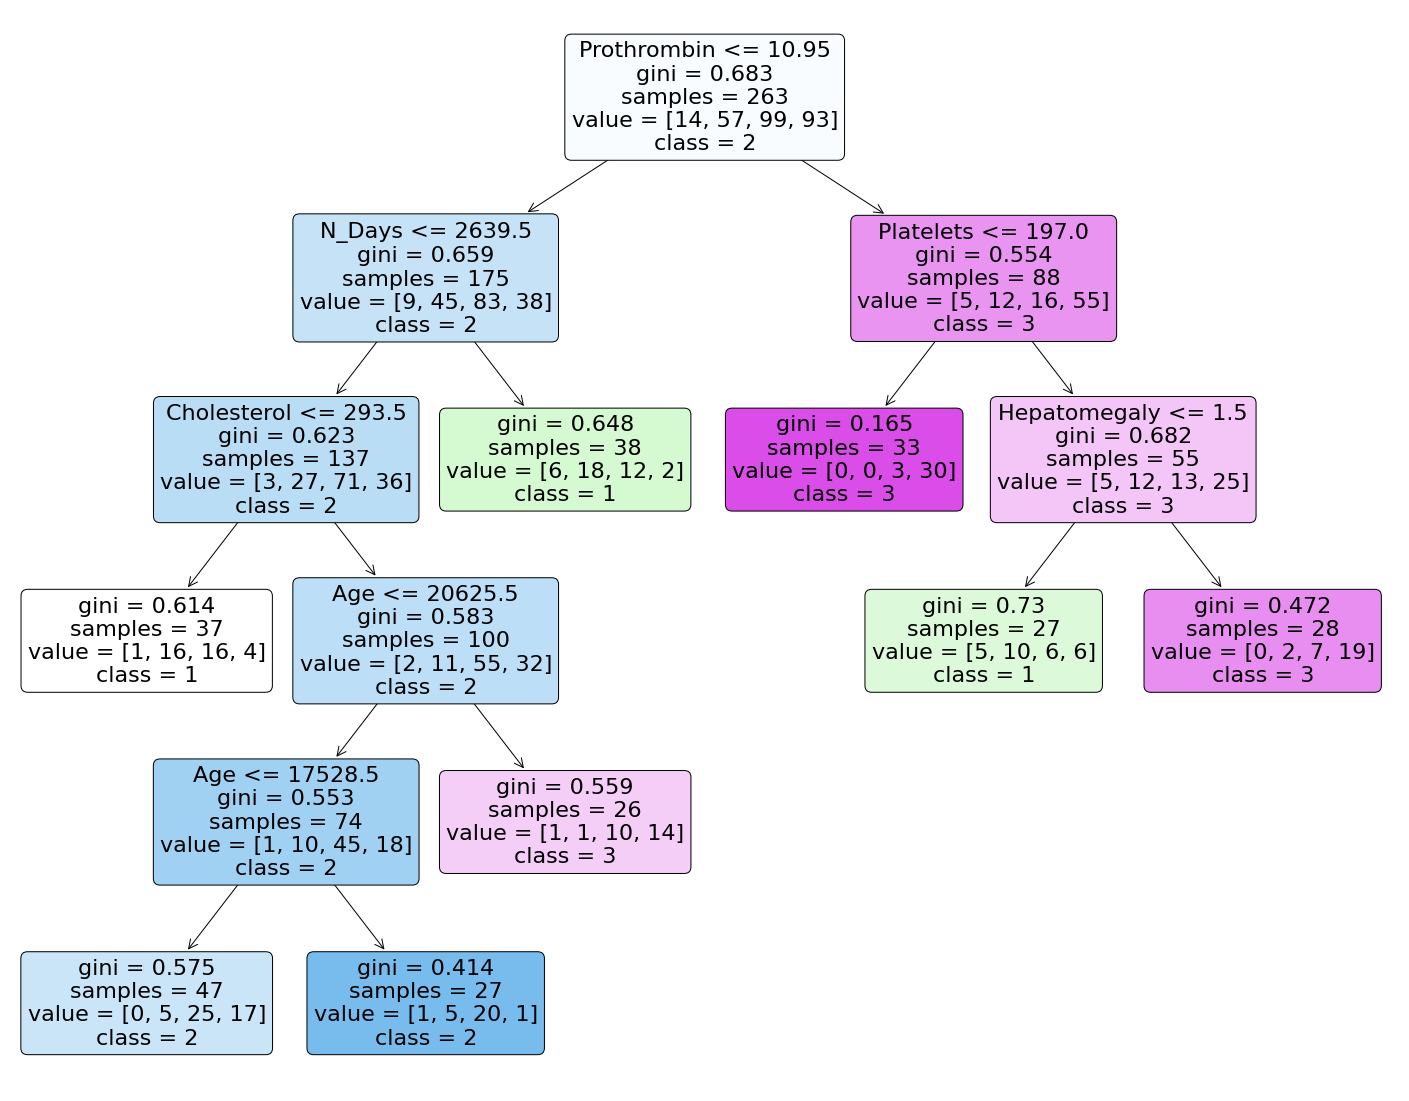

In [26]:
# Visualização da Árvore de Decisão
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=[25,20]) # width, height in inches
plot_tree(dt, 
          feature_names=col_names_dum,
          class_names=[str(x) for x in range(5)],
          filled=True, rounded=True)
plt.show()


In [27]:
# k-NN
# TODO falar sobre a maldição da dimensionalidade
# kNN n=5; sem Sex => 0.43640
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
standardized_data = scaler.transform(X_train)

m = 0
m_i = 1
for i in range(1, 236):
    knn = KNeighborsClassifier(n_neighbors=i)
    # knn.fit(standardized_data, y_train)
    # knn_preds = knn.predict(X_test)

    scores = cross_val_score(knn,
                             X=standardized_data,
                             y=y_train,
                             cv=10
                             )
    # print('CV accuracy:', *scores, sep='\n\t')
    mean = np.mean(scores)
    dp = np.std(scores)
    print('Average CV accuracy: i=%i %.3f +/- %.3f' % (i, mean, dp))

    if mean-dp > m:
        m = mean
        m_i = i

print(m, m_i)

knn = KNeighborsClassifier(n_neighbors=m_i)
knn.fit(standardized_data, y_train)


Average CV accuracy: i=1 0.376 +/- 0.092
Average CV accuracy: i=2 0.304 +/- 0.066
Average CV accuracy: i=3 0.403 +/- 0.093
Average CV accuracy: i=4 0.384 +/- 0.067
Average CV accuracy: i=5 0.453 +/- 0.072
Average CV accuracy: i=6 0.449 +/- 0.063
Average CV accuracy: i=7 0.434 +/- 0.067
Average CV accuracy: i=8 0.460 +/- 0.062
Average CV accuracy: i=9 0.434 +/- 0.076
Average CV accuracy: i=10 0.441 +/- 0.092
Average CV accuracy: i=11 0.423 +/- 0.105
Average CV accuracy: i=12 0.437 +/- 0.084
Average CV accuracy: i=13 0.468 +/- 0.071
Average CV accuracy: i=14 0.468 +/- 0.063
Average CV accuracy: i=15 0.468 +/- 0.084
Average CV accuracy: i=16 0.468 +/- 0.083
Average CV accuracy: i=17 0.456 +/- 0.070
Average CV accuracy: i=18 0.468 +/- 0.083
Average CV accuracy: i=19 0.441 +/- 0.078
Average CV accuracy: i=20 0.468 +/- 0.082
Average CV accuracy: i=21 0.471 +/- 0.091
Average CV accuracy: i=22 0.468 +/- 0.094
Average CV accuracy: i=23 0.464 +/- 0.080
Average CV accuracy: i=24 0.460 +/- 0.092
A

KNeighborsClassifier()

In [42]:
import numpy as np
import matplotlib.pyplot as plt


def plot_frontiers(X, y, model, feature_names, target_names, nclasses=3, pcolors="ryb"):

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])

    # Plot the training points
    for i, color in zip(range(nclasses), pcolors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=20)
    plt.legend()

small_data = Xdum[:,[2,3]]
knn_small = KNeighborsClassifier(n_neighbors=m_i)
knn_small.fit(small_data, y_train)

plot_frontiers(small_data,
                y,
                knn_small,
                col_names_dum,
                [str(x) for x in range(1, 5)],
                nclasses=4,
                pcolors="ryb")


ValueError: Found input variables with inconsistent numbers of samples: [83, 263]

In [28]:
# Naive Bayes
# nb, sem sex => 0.42601
# dummy_col_names = ['Status', 'Drug',  # 'Sex',
#                    'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

nb = GaussianNB()
nb.fit(X_train, y_train)

nb_preds = nb.predict(X_test)

scores = cross_val_score(nb,
                         X=X_train,
                         y=y_train,
                         cv=10
                         )
print('CV accuracy:', *scores, sep='\n\t')
print('Average CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

preds = nb.predict(X_test)
for i, p in enumerate(preds):
    print("Caso: ", X_test[i], "-->", p)


CV accuracy:
	0.3333333333333333
	0.2962962962962963
	0.37037037037037035
	0.2692307692307692
	0.4230769230769231
	0.46153846153846156
	0.2692307692307692
	0.5
	0.34615384615384615
	0.34615384615384615
Average CV accuracy: 0.362 +/- 0.075
Caso:  [4.79500000e+03 0.00000000e+00 0.00000000e+00 1.24190000e+04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.80000000e+00 3.69510563e+02 3.24000000e+00 9.76483871e+01
 1.98265577e+03 1.22556346e+02 1.24702128e+02 2.57024570e+02
 1.80000000e+01] --> 4
Caso:  [3.8800e+02 1.0000e+00 1.0000e+00 2.8018e+04 2.0000e+00 1.0000e+00
 1.0000e+00 2.0000e+00 1.4000e+00 2.0600e+02 3.1300e+00 3.6000e+01
 1.6260e+03 8.6800e+01 7.0000e+01 1.4500e+02 1.2200e+01] --> 4
Caso:  [2.2940e+03 0.0000e+00 2.0000e+00 1.5009e+04 1.0000e+00 2.0000e+00
 1.0000e+00 0.0000e+00 6.0000e-01 2.3500e+02 3.2000e+00 2.6000e+01
 1.7580e+03 1.0695e+02 6.7000e+01 2.2800e+02 1.0800e+01] --> 2
Caso:  [2.57400000e+03 0.00000000e+00 1.00000000e+00 1.92370000e+04
 1.00000000

### 2.2. Seleção e apresentação do melhor modelo

(remover) Apresentar todos os resultados para cada modelo obtido

* Elencar o critério de selecção
* Apresentar a árvore (se aplicável)
* Discutir os resultados


## 3. Validação do modelo final ajustado com um conjunto de validação independente

(remover) O ficheiro `test.csv` contém um conjunto de dados não usado para treinar o modelo definido no ponto #2. 
* Preparar o data set
* Correr o modelo selecionado como sendo o melhor nestes dados
* Apresentar os resultados para as métricas de validação
* Discutir os resultados alcançados confrontando os resultados com os obtidos anteriormente

## 4. Competição

(remover) Explicar os passos feitos para chegar à solução submetida na competição, tendo em conta:

* A escolha dos parâmetros usados pelos classificadores
* A escolha de atributos mais relevantes para a aprendizagem dos modelos
    

In [30]:
from typing import Callable
df_cirrose_test = pd.read_csv("test.csv")

col_idxs = [x for x in range(1, 19)]
col_names = np.array(df_cirrose_test.columns)[col_idxs]

dummy_col_names = ['Status', 'Drug',# 'Sex',
                   'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

df_cirrose_test_X = df_cirrose_test[col_names]
df_cirrose_test_X.drop('Sex', inplace=True)
df_cirrose_test_Xdum = df_cirrose_test_X.copy()
replace_dummies(df_cirrose_test_Xdum)

# df_cirrose_test_Xdum.drop('Sex', axis=1, inplace=True)
Xdum = df_cirrose_test_Xdum.values


def pred(classifier: Callable, data, classifier_name: str):
    preds = classifier.predict(data)
    # print(f'{classifier_name} {}')
    
# scaler = StandardScaler()
# scaler.fit(Xdum)
# standardized_data = scaler.transform(Xdum)

# pred(nb, Xdum, 'Naive Bayes')
preds = nb.predict(Xdum)
# preds = knn.predict(standardized_data)
# preds = dt.predict(Xdum)


# # list(zip(df_cirrose_Xdum.shape, preds))
df_out = pd.DataFrame({'ID': df_cirrose_test['ID'], 'Stage': preds})

df_out.to_csv('submission.csv', index=False)

KeyError: "['Sex'] not found in axis"

In [17]:
df_cirrose_test_Xdum

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,329,939,0,1,22767,0,1,1,1,0,1.7,434.000000,3.35,39.000000,1713.000000,171.000000,100.000000,234.00000,10.2
1,330,1302,0,1,22111,1,1,2,1,0,6.6,1000.000000,3.07,88.000000,3150.000000,193.000000,133.000000,299.00000,10.9
2,331,1443,0,0,14975,0,0,0,0,0,1.2,369.510563,2.80,97.648387,1982.655769,122.556346,124.702128,120.00000,11.0
3,332,2944,0,1,14812,0,1,1,1,0,1.9,448.000000,3.83,60.000000,1052.000000,127.100000,175.000000,181.00000,9.8
4,333,3853,1,2,19025,0,1,1,1,0,0.8,276.000000,3.60,54.000000,4332.000000,99.330000,143.000000,273.00000,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,407,1297,1,1,18719,1,1,2,1,0,7.3,426.000000,3.93,262.000000,2424.000000,145.700000,218.000000,252.00000,10.5
79,408,2576,0,2,17323,0,1,1,1,0,0.5,316.000000,3.65,68.000000,1716.000000,187.550000,71.000000,356.00000,9.8
80,409,2111,1,0,19724,0,0,0,0,0,1.0,369.510563,3.60,97.648387,1982.655769,122.556346,124.702128,257.02457,12.1
81,410,2812,1,0,18628,0,0,0,0,0,3.4,369.510563,3.92,97.648387,1982.655769,122.556346,124.702128,257.02457,9.3
